# Section 1: Big Data Management 

### For this project, I utilize Cloud Firestore as the NoSQL database. *"Cloud Firestore is a NoSQL document database that lets you easily store, sync, and query data for your mobile and web apps - at global scale."*

### **NB** Alongside this notebook, there's a read me file which explains how one exactly can set up Firestore on Google Cloud Console. It explains how one can set up authentication by using a key (the json file which is shown in the next cell), and is used to connect us to the Google Cloud Console. Please follow the instruction there to set up a Firestore Connection (if you don't have already) before proceeding to this file. 


In [1]:
# seting up Firestore access 

%env GOOGLE_APPLICATION_CREDENTIALS=C:\Users\jon\bigdata-finalproject-407907-d6bdc0fc647a.json

env: GOOGLE_APPLICATION_CREDENTIALS=C:\Users\jon\bigdata-finalproject-407907-d6bdc0fc647a.json


In [ ]:
# import sys
# !{sys.executable} -m pip install --upgrade google-cloud-firestore

In [2]:
from google.cloud import firestore

# establish a connection with your db through the key
db = firestore.Client()

c:\Users\jon\AppData\Local\Programs\Python\Python38\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Information about the data that were used for the project: For anyone interested in replicating this, the data can be reached using this [link](https://dumps.wikimedia.org/enwiki/latest/) and download the following file "enwiki-latest-pages-articles-multistream.xml.bz2". The file is big around 22 GB and hence, it requires quite some time to be downloaded. The Big Data Processing steps, which are shown below, are able to handle both the bz2 compressed data and the decompressed xml data. After downloading it, it can be placed in the same path as this ipynb is located on your system.


In [3]:
# source for the main parts of code can be found here: 
# https://github.com/daveshap/PlainTextWikipedia?tab=readme-ov-file

# However, I adjusted the code so that it does not save the json contents locally 
# but to save them directly on Firestore. This is a first step of Big Data 
# management routine, since saving the contents of an xml file of 92 GB **locally**
# sounds like a disaster. In that way we alleviate the pain of Big Data Management.  

from threading import Thread
import json
import re
from html2text import html2text as htt
import wikitextparser as wtp


def dewiki(text):
    text = wtp.parse(text).plain_text()  # wiki to plaintext 
    text = htt(text)  # remove any HTML
    text = text.replace('\\n',' ')  # replace newlines
    text = re.sub('\s+', ' ', text)  # replace excess whitespace
    return text


def analyze_chunk(text):
    try:
        if '<redirect title="' in text:  # this is not the main article
            return None
        if '(disambiguation)' in text:  # this is not an article
            return None
        else:
            title = text.split('<title>')[1].split('</title>')[0]
            title = htt(title)
            if ':' in title:  # most articles with : in them are not articles we care about
                return None
        serial = text.split('<id>')[1].split('</id>')[0]
        content = text.split('</text')[0].split('<text')[1].split('>', maxsplit=1)[1]
        content = dewiki(content)
        return {'title': title.strip(), 'text': content.strip(), 'id': serial.strip()}
    except Exception as oops:
        print(oops)
        return None


# I adjusted the functions below so that instead of saving the json files locally to save 
# them on cloud DB (Firestore)            
def save_article_to_cloud(article, collection_name):
    doc = analyze_chunk(article)
    if doc:
        print('SAVING on Firestore:', doc['title'])
        filename = doc['title'] + '.json'    
        document_title = doc.get('title', None)
        if document_title is not None:
            collection_ref = db.collection(collection_name)
            doc_ref = collection_ref.document(document_title)
            doc_ref.set(doc)
            print(f'Data saved to Firestore with document title: {document_title}')
        else:
            print('Error: Document title not found in the JSON data.')


def process_file_text_cloud(filename, collection_name):
    article = ''
    with open(filename, 'r', encoding='utf-8') as infile:
        for line in infile:
            if '<page>' in line:
                article = ''
            elif '</page>' in line:  # end of article
                Thread(target=save_article_to_cloud, args=(article, collection_name)).start()
            else:
                article += line              

In [7]:
# Here, we perform the saving routine. We only need 2 arguments to be set in the process_file_text_cloud
# function; (1) a local path that reads the xml file from a local directory, and (2) the collection name 
# for the Firestore storage

# NB NB The runtime here is very big, can take a day or two since they data is heavy! For tha regard, 
# I did not run the process for entire data, instead I run it for a while to show its capabilities 
# and how it operates.

collection_name = "wikipedia_data"

wiki_xml_file = 'L:/MSc in Data Science/3rd_Semester/Big Data Management and Processing/Final_Project/enwiki-latest-pages-articles-multistream.xml'  

if __name__ == '__main__':
    process_file_text_cloud(wiki_xml_file, collection_name)

SAVING on Firestore: Albedo
SAVING on Firestore: An American in Paris
SAVING on Firestore: Animalia (book)
SAVING on Firestore: Actrius
SAVING on Firestore: International Atomic Time
SAVING on Firestore: Alain Connes
SAVING on Firestore: Altruism
SAVING on Firestore: Abraham Lincoln
SAVING on Firestore: Astronomer
SAVING on Firestore: List of Atlas Shrugged characters
SAVING on Firestore: Arithmetic mean
SAVING on Firestore: Allan Dwan
SAVING on Firestore: Anthropology
SAVING on Firestore:

KeyboardInterrupt: 

 Austroasiatic languages
SAVING on Firestore: Ayn Rand


SAVING on Firestore: Andorra
SAVING on Firestore: Alabama
SAVING on Firestore: American Football Conference
SAVING on Firestore: Aristotle
SAVING on Firestore: Andre Agassi
SAVING on Firestore: Afroasiatic languages
SAVING on Firestore: ASCII
SAVING on Firestore: Academy Award for Best Production Design
Data saved to Firestore with document title: Albedo
Data saved to Firestore with document title: Arithmetic mean
Data saved to Firestore with document title: Allan Dwan
Data saved to Firestore with document title: Actrius
Data saved to Firestore with document title: International Atomic Time
Data saved to Firestore with document title: Anthropology
Data saved to Firestore with document title: AstronomerData saved to Firestore with document title: Altruism

Data saved to Firestore with document title: Austroasiatic languages
Data saved to Firestore with document title: Abraham Lincoln
Data saved to Firestore with document title: Ayn Rand
Data saved to Firestore with document title: Andor

In [4]:
# In this case, we use a more efficient method by a two-step approach.
#                                   Step (1).
# In stead of reading the entire xml file which is huge (92GB), we read the 
# zipped/compressed bz2 file which is still big (22GB) but way less than the xml. 
#                                   Step (2) 
# Since it's a big (still) file, we read chunks of data so that to alleviate 
# the memory contraint of our system. This is done by the chunk_size below and the 
# break condition which helps us to stop iterating in the entire document and iterate
# only until the chunk_size is reached. After reached, it process saves the chunks on 
# Firestore, and after saving we continue with the next chunk. In that case, we transfer 
# the burden from memory to disk but disk is the cloud environment.


#!pip install rarfile    

import bz2

bz2_path = 'L:/MSc in Data Science/3rd_Semester/Big Data Management and Processing/Final_Project/enwiki-latest-pages-articles-multistream.xml.bz2'

def process_bz2_file(bz2_path, chunk_size=1024):

    article = ''
    
    with bz2.open(bz2_path, 'rt', encoding='utf-8') as bz2_file:
        while True:
            chunk = bz2_file.read(chunk_size)
            if not chunk:
                break  # End of file           
            
            lines = chunk.split('\n')
            for line in lines:
                if '<page>' in line:
                    article = ''
                elif '</page>' in line:  # end of article
                    Thread(target=save_article_to_cloud, args=(article, collection_name)).start()
                else:
                    article += line


In [23]:
# NB Similarly here, I did not run the entire data. Even thought it's much easier for the 
# process to be run, thanks to write I/O of chunks of data, still requires quite some time
# to be run entirely. 

# Run the process 
process_bz2_file(bz2_path)


SAVING on Firestore: An American in Paris
Data saved to Firestore with document title: An American in Paris
SAVING on Firestore: Abraham Lincoln
SAVING on Firestore: International Atomic Time
SAVING on Firestore: Allan Dwan
SAVING on Firestore: Ayn Rand
SAVING on Firestore: Academy Award for Best Production Design
SAVING on Firestore: Anthropology
Data saved to Firestore with document title: Abraham Lincoln
Data saved to Firestore with document title: International Atomic Time
SAVING on Firestore: ASCII
Data saved to Firestore with document title: Allan Dwan
Data saved to Firestore with document title: Ayn Rand
SAVING on Firestore: Animal Farm
Data saved to Firestore with document title: Academy Award for Best Production Design
SAVING on Firestore: Arraignment
SAVING on Firestore: America the Beautiful
SAVING on Firestore: Bitumen
Data saved to Firestore with document title: Anthropology
SAVING on Firestore: Aardwolf
SAVING on Firestore: Aruba
Data saved to Firestore with document titl

KeyboardInterrupt: 

Data saved to Firestore with document title: Geography of ArmeniaData saved to Firestore with document title: Antisemitism

Data saved to Firestore with document title: Transport in Armenia
Data saved to Firestore with document title: Economy of Armenia
Data saved to Firestore with document title: Algebraic number
Data saved to Firestore with document title: August 2
Data saved to Firestore with document title: Afro Celt Sound System
Data saved to Firestore with document title: Ancient philosophy
Data saved to Firestore with document title: Anaximander
Data saved to Firestore with document title: Architect
Data saved to Firestore with document title: April 1
Data saved to Firestore with document title: Aleister Crowley
Data saved to Firestore with document title: Amber Diceless Roleplaying Game
Data saved to Firestore with document title: Acoustics
Data saved to Firestore with document title: Telecommunications in Anguilla
Data saved to Firestore with document title: Alan Turing
Data s

### Here, we read from our collection of data in Firestore the documents we want 

In [5]:
test_1_db = db.collection(u'wikipedia_data') # collection name 
doc_ref = test_1_db.document(u'Albedo') # this is the name of one file in the JSON. 

doc = doc_ref.get()
if doc.exists:
    print(doc.id, doc.get('title'), doc.to_dict())

Albedo Albedo {'text': 'Albedo (; ) is the fraction of sunlight that is diffusely reflected by a body. It is measured on a scale from 0 (corresponding to a black body that absorbs all incident radiation) to 1 (corresponding to a body that reflects all incident radiation).Surface albedo is defined as the ratio of radiosity Je to the irradiance Ee (flux per unit area) received by a surface. The proportion reflected is not only determined by properties of the surface itself, but also by the spectral and angular distribution of solar radiation reaching the Earth\'s surface. These factors vary with atmospheric composition, geographic location, and time (see position of the Sun). While bi-hemispherical reflectance is calculated for a single angle of incidence (i.e., for a given position of the Sun), albedo is the directional integration of reflectance over all solar angles in a given period. The temporal resolution may range from seconds (as obtained from flux measurements) to daily, monthly

In [6]:
doc.to_dict()['text']

'Albedo (; ) is the fraction of sunlight that is diffusely reflected by a body. It is measured on a scale from 0 (corresponding to a black body that absorbs all incident radiation) to 1 (corresponding to a body that reflects all incident radiation).Surface albedo is defined as the ratio of radiosity Je to the irradiance Ee (flux per unit area) received by a surface. The proportion reflected is not only determined by properties of the surface itself, but also by the spectral and angular distribution of solar radiation reaching the Earth\'s surface. These factors vary with atmospheric composition, geographic location, and time (see position of the Sun). While bi-hemispherical reflectance is calculated for a single angle of incidence (i.e., for a given position of the Sun), albedo is the directional integration of reflectance over all solar angles in a given period. The temporal resolution may range from seconds (as obtained from flux measurements) to daily, monthly, or annual averages.Un

In [7]:
# let us query the datastream
docs = test_1_db.stream()

query = test_1_db.where('title', '==', 'Albedo')
docs = query.stream()

for doc in docs:    
    print(doc.to_dict())


{'text': 'Albedo (; ) is the fraction of sunlight that is diffusely reflected by a body. It is measured on a scale from 0 (corresponding to a black body that absorbs all incident radiation) to 1 (corresponding to a body that reflects all incident radiation).Surface albedo is defined as the ratio of radiosity Je to the irradiance Ee (flux per unit area) received by a surface. The proportion reflected is not only determined by properties of the surface itself, but also by the spectral and angular distribution of solar radiation reaching the Earth\'s surface. These factors vary with atmospheric composition, geographic location, and time (see position of the Sun). While bi-hemispherical reflectance is calculated for a single angle of incidence (i.e., for a given position of the Sun), albedo is the directional integration of reflectance over all solar angles in a given period. The temporal resolution may range from seconds (as obtained from flux measurements) to daily, monthly, or annual av

c:\Users\jon\AppData\Local\Programs\Python\Python38\lib\site-packages\google\cloud\firestore_v1\base_collection.py:295: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


In [44]:
# query multiple words
queries_online = ['Albedo', 'Ancient philosophy', 'Anisotropy', 'Anchor']

docs2 = test_1_db.stream()

query2 = test_1_db.where('title', 'in', queries_online)
docs2 = query2.stream()

documents_dict = {} # for saving
for doc2 in docs2:   
    document_data = doc2.to_dict()
    title = document_data['title']
    documents_dict[title] = document_data 

documents_dict
    

c:\Users\jon\AppData\Local\Programs\Python\Python38\lib\site-packages\google\cloud\firestore_v1\base_collection.py:295: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


{'Albedo': {'text': 'Albedo (; ) is the fraction of sunlight that is diffusely reflected by a body. It is measured on a scale from 0 (corresponding to a black body that absorbs all incident radiation) to 1 (corresponding to a body that reflects all incident radiation).Surface albedo is defined as the ratio of radiosity Je to the irradiance Ee (flux per unit area) received by a surface. The proportion reflected is not only determined by properties of the surface itself, but also by the spectral and angular distribution of solar radiation reaching the Earth\'s surface. These factors vary with atmospheric composition, geographic location, and time (see position of the Sun). While bi-hemispherical reflectance is calculated for a single angle of incidence (i.e., for a given position of the Sun), albedo is the directional integration of reflectance over all solar angles in a given period. The temporal resolution may range from seconds (as obtained from flux measurements) to daily, monthly, o

# Section 2: Big Data Processing 

In [8]:
# Functions that help us with text preprocessing 

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer 
nltk.download('punkt') 



# function to remove punctuations 
def punctuation_removal(data_string):
    punctuations = [",", ".", "?", "!", "'", "+", "(", ")", ":",
                            "-", "_", "/", "<", "|", "\"", ">", " \ ", ";",
                            "{", "}", "\\", "*", '–', '&', '^', '$', '#', '@', '!']
    for punc in punctuations:
        for i in range(0,len(data_string)):
         
         data_string[i] = data_string[i].replace(punc, "")
    return data_string

# function to remove punctuation for specific cases 
def punctuation_removal_2(data_string):
    punctuations = ["="]
    for punc in punctuations:
        for i in range(0,len(data_string)):
         
         data_string[i] = data_string[i].replace(punc, "")
    return data_string


# function to remove numbers 
def remove_numbers(text):
    rm_n = re.sub(r'\d+', '', text)
    return rm_n

def tokenizer(text, output_in_list = True):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token.lower() for token in tokens if token.isalpha()]

    if output_in_list:
        return filtered_tokens
    else:
        return ' '.join(filtered_tokens)
       

# function to remove stopwords from a given text string
def remove_stopwords(text):
    """ 

    The stop_words function take out all the most common used words that are within
    the nltk and gensim libraries.

    """
    
    # define stopwords
    stop_words = set(stopwords.words('english')).union(set(STOPWORDS))

    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    # filtered_tokens = tokenizer(text)
    return ' '.join(filtered_tokens)


# function for stemming of text data
def apply_stemming(tokenized_text):
    """ 
    Porter Stemming of the text 
    """
    stemmer = PorterStemmer() 
    return' '.join([stemmer.stem(word) for word in tokenized_text.split()])   


# function for text Lemmatizer
def word_lemmatizer(text):
   lemmatizer = WordNetLemmatizer()
   lemma_words = [lemmatizer.lemmatize(l) for l in text.split()]
   return " ".join(lemma_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Pre-processing of the text data 
text_pre_punc     = punctuation_removal(str.split(doc.to_dict()['text']))
test_rej          = ' '.join(str(element) for element in text_pre_punc)
text_pre_rm       = remove_stopwords(test_rej)
text_pre          = apply_stemming(text_pre_rm)
text_pre          = remove_numbers(text_pre)

### Functions to create two summarizers

In [10]:
# !pip install sumy
# !pip3 install spacy 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest


# Summarizer using the TextRank Summarization
def summarizer_textrank(text):
    '''    
    TextRank summarization: 
    code idea: https://www.turing.com/kb/5-powerful-text-summarization-techniques-in-python
    '''

    from sumy.parsers.plaintext import PlaintextParser
    from sumy.nlp.tokenizers import Tokenizer
    from sumy.summarizers.text_rank import TextRankSummarizer

    summarizer = TextRankSummarizer()
    parser     = PlaintextParser.from_string(text, Tokenizer("english"))
    
    summary  = summarizer(parser.document, 2)
    text_summary = ""
    for sentence in summary:
        text_summary+=str(sentence)

    text_summary_final = ' '.join(str(element) for element in punctuation_removal_2(str.split(text_summary)))
    return text_summary_final



# Summarizer using the Abstract text Summarization
def summarizer_abstracttext(text, per):
    ''' 
     Abstract Text Summarization: 
     source code: https://www.activestate.com/blog/how-to-do-text-summarization-with-python/
     per: the percentage of summary (compared to the text) that will be extracted as
          summary 
    '''
    nlp = spacy.load('en_core_web_sm')
    doc= nlp(text)
    tokens=[token.text for token in doc]
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()]
    select_length=int(len(sentence_tokens)*per)
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    final_summary=[word.text for word in summary]
    summary=''.join(final_summary)
    return summary

# Function that visualizes the summarization above better for a 
# human eye, by breaking the one line to multiple (like a text).
def break_into_lines(summary, words_per_line=20, new_line = True):
    '''
    Function that breaks the big horizonal line in the notebook
    to many smaller sentences. 
    '''
    if new_line:
        words = summary.split()
        lines = [' '.join(words[i:i+words_per_line]) for i in range(0, len(words), words_per_line)]
        return '\n'.join(lines)
    else:
        words = summary.split()
        lines = [' '.join(words[i:i+words_per_line]) for i in range(0, len(words), words_per_line)]
        return ''.join(lines)


In [11]:
# TextRank Summarization
summary_textrank_word1 = tokenizer(summarizer_textrank(doc.to_dict()['text']), output_in_list = False)
formatted_summary_textrank_word1 = break_into_lines(summary_textrank_word1, words_per_line=20)
# print(formatted_summary_textrank_word1)

# Abstract text Summarization
summary_abstract_word1 = summarizer_abstracttext(doc.to_dict()['text'], 0.02)
formatted_summary_abstract_word1 = break_into_lines(summary_abstract_word1, words_per_line=20)
# print(formatted_summary_abstract_word1)

### Computing Cosine and Jaccard Similarity between the texts of 2 different queried words.

In [12]:
# retrive another word for computing the texts similarity 
doc_ref_2 = test_1_db.document(u'Geography of Antarctica') 
doc_2     = doc_ref_2.get()
if doc_2.exists:
    print(doc_2.id, doc_2.get('title'), doc_2.to_dict())

# pre-processing the second queried word    
text_pre2     = punctuation_removal(str.split(doc_2.to_dict()['text']))
test_rej2     = ' '.join(str(element) for element in text_pre2)
text_pre_rm2  = remove_stopwords(test_rej2)
text_pre2     = apply_stemming(text_pre_rm2)
text_pre2     = remove_numbers(text_pre2)


Geography of Antarctica Geography of Antarctica {'text': 'The geography of Antarctica is dominated by its south polar location and, thus, by ice. The Antarctic continent, located in the Earth\'s southern hemisphere, is centered asymmetrically around the South Pole and largely south of the Antarctic Circle. It is washed by the Southern (or Antarctic) Ocean or, depending on definition, the southern Pacific, Atlantic, and Indian Oceans. It has an area of more than 14 million km2. Antarctica is the largest ice desert in the world.Some 98% of Antarctica is covered by the Antarctic ice sheet, the world\'s largest ice sheet and also its largest reservoir of fresh water. Averaging at least 1.6 km thick, the ice is so massive that it has depressed the continental bedrock in some areas more than 2.5 km below sea level; subglacial lakes of liquid water also occur (e.g., Lake Vostok). Ice shelves and rises populate the ice sheet on the periphery. The present Antarctic ice sheet accounts for 90 per

In [16]:
# Abstract text Summarization for the second queried word.
summary_abstract_word2 = summarizer_abstracttext(doc_2.to_dict()['text'], 0.02)
formatted_summary_abstract_word2 = break_into_lines(summary_abstract_word2, words_per_line=20, new_line=True)
print(formatted_summary_abstract_word2)


As the most active volcano in the Antarctic peninsula, it has been studied closely since its initial discovery in 1820.There
are four volcanoes on the mainland of Antarctica that areconsidered to be active on the basis of observed fumarolic activity
or "recent" tephra deposits: Mount Melbourne (2,730 m) (74°21'S., 164°42'E.), a stratovolcano; Mount Berlin (3,500 m) (76°03'S., 135°52'W.), a stratovolcano;
Mount Kauffman (2,365 m) (75°37'S., 132°25'W.), a stratovolcano; and Mount Hampton (3,325 m) (76°29'S., 125°48'W.), a volcanic caldera.Buckle Island in
the Balleny Islands (66°50'S., 163°12'E.), Penguin Island (62°06'S., 57°54'W.), Paulet Island (63°35'S., 55°47'W.), and Lindenberg Island (64°55'S., 59°40'W.) are also
considered to be active.Ross Ice Shelf (166°E – 155°W)For all ice shelves see List of Antarctic ice shelves.===Islands===For a list
of all Antarctic islands see List of Antarctic and sub-Antarctic islands.==East Antarctica==East Antarctica is the larger part of the contin

In [13]:
# Functions for computing the Cosine and Jaccard similarities

# Cosine  similarity of the two texts
# source code: https://stackoverflow.com/questions/15173225/calculate-cosine-similarity-given-2-sentence-strings
import math
import re
from collections import Counter
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)


# Computing the jaccard similarity between the two pre-processed texts 
def get_jaccard_sim(str1, str2): 
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [14]:
# Calculating the cosine between the two preprocessed texts 
vector1 = text_to_vector(text_pre)
vector2 = text_to_vector(text_pre2)

cosine = get_cosine(vector1, vector2)

print("Cosine:", cosine)

# Calculating the Jaccard between the two preprocessed texts 
jc_sim = get_jaccard_sim(text_pre, text_pre2)
print("Jaccard:", jc_sim)

Cosine: 0.13919273111888328
Jaccard: 0.6595744680851063


### Below, is a final graph that concludes all the analytics that were exctracted above. 

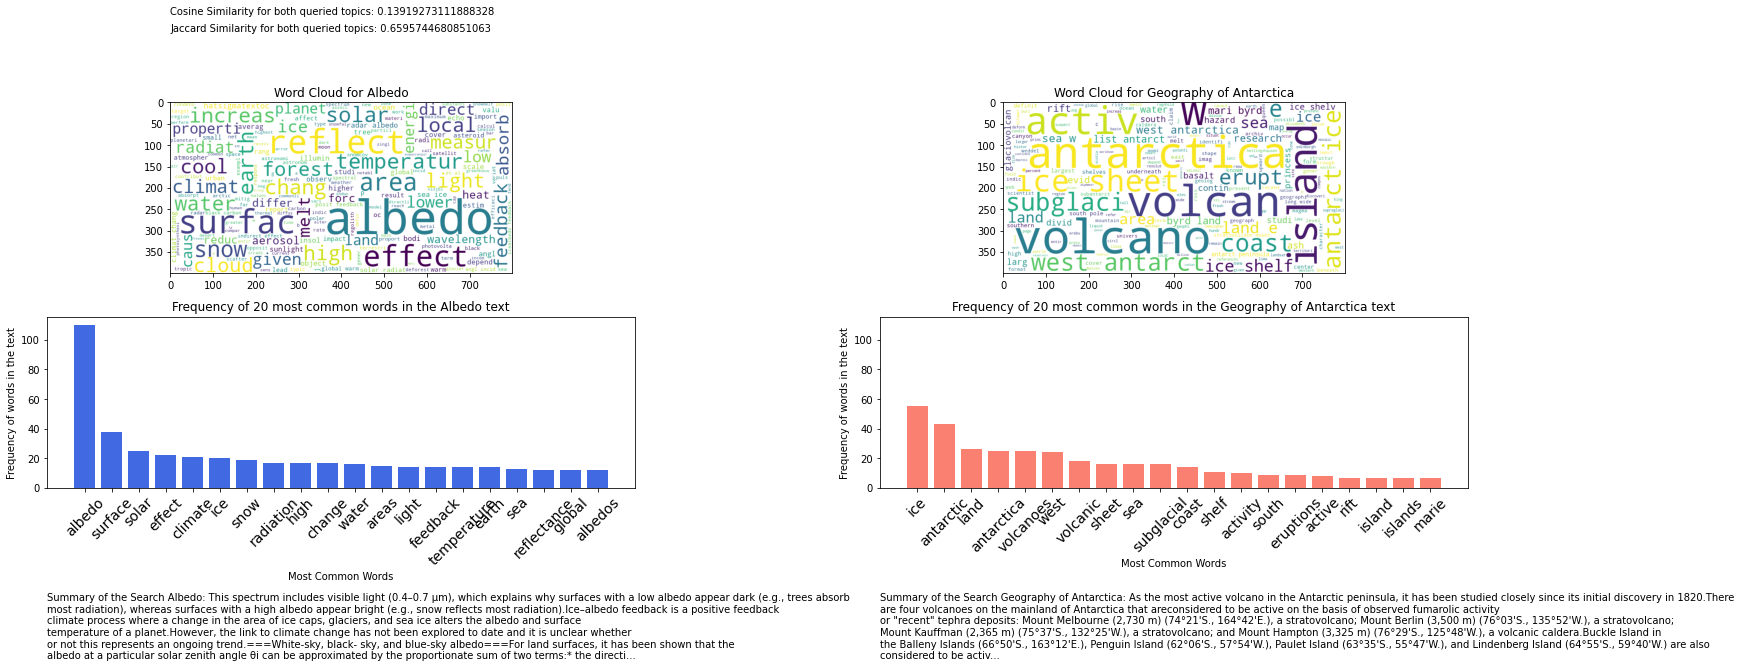

In [20]:
from IPython.display import display
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib as mpl
from collections import Counter


try:
    # This is the first case where we  have to show the analytics of two texts.


    # Similarities and Summary texts
    cosine_similarity        = cosine
    jaccard_similarity       = jc_sim
    summary_text_1           = formatted_summary_abstract_word1
    summary_text_2           = formatted_summary_abstract_word2

    # Truncate the summary for display only part of it
    # as a preview case. 
    truncated_summary_text_1 = summary_text_1[:750] + "..."
    truncated_summary_text_2 = summary_text_2[:750] + "..."

    # WordCloud data for both texts
    wordcloud_data           = " ".join(text_pre.split()) 
    wordcloud_data2          = " ".join(text_pre2.split()) 

    # data for bar plot - chart 3
    counter = Counter(text_pre_rm.lower().split())
    top_20_words = counter.most_common(20)
    words, frequencies = zip(*top_20_words)

    # data for bar plot - chart 4
    counter2 = Counter(text_pre_rm2.lower().split())
    top_20_words2 = counter2.most_common(20)
    words2, frequencies2 = zip(*top_20_words2)

    # figure with four subplots and additional space below charts
    fig, axs = plt.subplots(2, 2, figsize=(24, 12), gridspec_kw={"height_ratios": [1.5, 1.5]})

    # common output above charts 1 and 2
    axs[0, 0].text(0, 1.5, f"Cosine Similarity for both queried topics: {cosine_similarity}", transform=axs[0, 0].transAxes, ha='left', va='bottom')
    axs[0, 0].text(0, 1.4, f"Jaccard Similarity for both queried topics: {jaccard_similarity}", transform=axs[0, 0].transAxes, ha='left', va='bottom')

    # Display WordCloud on the top-left chart
    axs[0, 0].imshow(WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(wordcloud_data))
    axs[0, 0].set_title(f"Word Cloud for {doc.get('title')}")

    # Display WordCloud on the top-right chart
    axs[0, 1].imshow(WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(wordcloud_data2))
    axs[0, 1].set_title(f"Word Cloud for {doc_2.get('title')}")

    # Plot bar chart for text 1
    axs[1, 0].bar(words, frequencies, color='royalblue')
    axs[1, 0].set_title(f"Frequency of 20 most common words in the {doc.get('title')} text")
    axs[1, 0].set_xlabel("Most Common Words")
    axs[1, 0].set_ylabel("Frequency of words in the text")
    axs[1, 0].tick_params(axis='x', rotation=45, labelsize=14)

    # Display summary outputs below bar plot text 1
    axs[1, 0].text(0, -1.0, f"Summary of the Search {doc.get('title')}: {truncated_summary_text_1}", transform=axs[1, 0].transAxes)
    # axs[1, 1].text(0, -1.0, f"Summary of Text 4: {truncated_summary_text_2}", transform=axs[1, 1].transAxes)

    # Plot bar chart for text 2
    axs[1, 1].bar(words2, frequencies2, color='salmon')
    axs[1, 1].set_title(f"Frequency of 20 most common words in the {doc_2.get('title')} text")
    axs[1, 1].set_xlabel("Most Common Words")
    axs[1, 1].set_ylabel("Frequency of words in the text")
    axs[1, 1].tick_params(axis='x', rotation=45, labelsize=14)

    # Display summary outputs below bar plot text 2
    axs[1, 1].text(0, -1.0, f"Summary of the Search {doc_2.get('title')}: {truncated_summary_text_2}", transform=axs[1, 1].transAxes)

    # share y axis for better comparisons and visualization 
    axs[1, 0].get_shared_y_axes().join(axs[1, 0], axs[1, 1])

    
    plt.tight_layout()
    plt.show()
    
except: 
    # This is the case where we only have to show the analytics of one text. 
    
    truncated_summary_text_1 = summary_text_1[:1000] + "..."

    # WordCloud data
    wordcloud_data = " ".join(text_pre.split())  # Adjust as needed

    # data for bar plot 
    counter = Counter(text_pre_rm.lower().split())
    top_20_words = counter.most_common(20)
    words, frequencies = zip(*top_20_words)

    # figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))


    # WordCloud chart
    axs[0].imshow(WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(wordcloud_data))
    axs[0].set_title("Word Cloud for Text 1")

    # truncated summary text below the first chart
    axs[0].text(0, -1, f"Summary of Text 1: {truncated_summary_text_1}", transform=axs[0].transAxes, ha='left', va='bottom', fontsize = 12)

    # Plot bar
    axs[1].bar(words, frequencies, color='royalblue')
    axs[1].set_title("Frequency of 20 most common words in the text")
    axs[1].set_xlabel("Most Common Words")
    axs[1].set_ylabel("Frequency of words in the text")
    axs[1].tick_params(axis='x', rotation=45, labelsize=14)

    plt.tight_layout()
    plt.show()    
    